In [1]:
# Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Настройки для воспроизводимости
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\sad type\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Выбор начальных условий
## Выбор набора данных
Для работы выберем датасет Kvasir-SEG - это набор данных для сегментации полипов в желудочно-кишечном тракте. Это важная медицинская задача для ранней диагностики рака.

Датасет содержит 1000 изображений с соответствующими масками сегментации. Это хороший размер - не слишком большой для быстрого обучения, но достаточный для получения значимых результатов.

Found 1000 images and 1000 masks


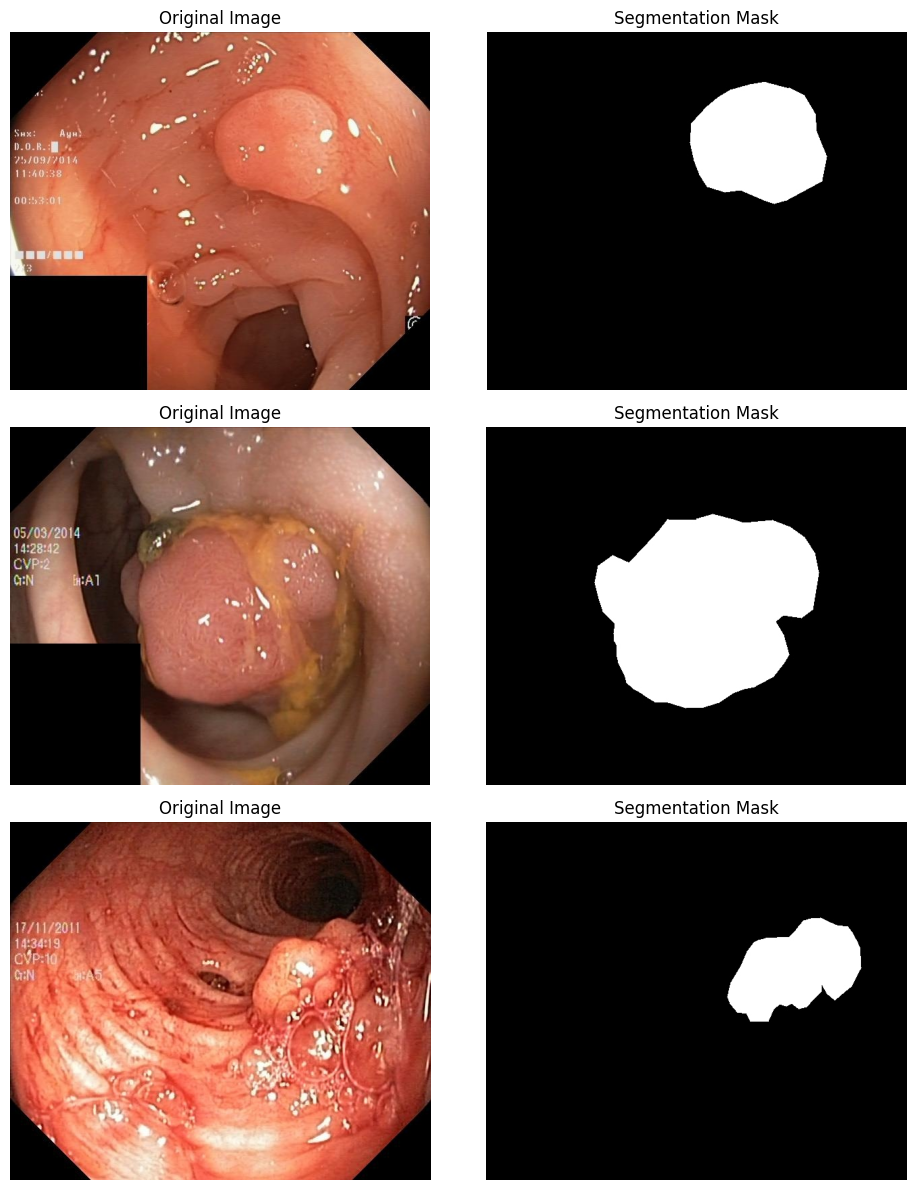

In [3]:
data_dir = "Kvasir-SEG\\Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Проверим наличие данных
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.jpg')])

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

# Визуализация примеров данных
def plot_examples(images, masks, num_examples=3):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples*4))
    
    for i in range(num_examples):
        idx = random.randint(0, len(images)-1)
        
        img = Image.open(os.path.join(images_dir, images[idx]))
        mask = Image.open(os.path.join(masks_dir, masks[idx]))
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Segmentation Mask")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_examples(image_files, mask_files)

## Выбор метрик качества
Для задачи семантической сегментации выберем следующие метрики:

* Dice Coefficient (F1-score) - популярная метрика в медицинской сегментации, хорошо работает при несбалансированных классах

* IoU (Intersection over Union) - стандартная метрика для задач сегментации

* Accuracy - доля правильно классифицированных пикселей

* Precision - точность предсказаний положительного класса

* Recall - полнота предсказаний положительного класса

In [4]:
# Определим функции для вычисления метрик
def calculate_metrics(pred, target):
    pred = pred > 0.5  # бинаризация предсказаний
    target = target > 0.5  # бинаризация масок
    
    smooth = 1e-6  # для численной стабильности
    
    # True Positives, False Positives, False Negatives
    tp = (pred & target).sum().float()
    fp = (pred & ~target).sum().float()
    fn = (~pred & target).sum().float()
    tn = (~pred & ~target).sum().float()
    
    # Вычисление метрик
    accuracy = (tp + tn) / (tp + fp + fn + tn + smooth)
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    dice = (2 * tp) / (2 * tp + fp + fn + smooth)
    iou = tp / (tp + fp + fn + smooth)
    
    return {
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'dice': dice.item(),
        'iou': iou.item()
    }

## Создание бейзлайна и оценка качества
### Обучение моделей из segmentation_models.pytorch

Train: 600, Val: 200, Test: 200


Epoch 1/5: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s]


Epoch 1/5
Train Loss: 0.3609, Val Loss: 0.2505
Validation Metrics:
Accuracy: 0.9319
Precision: 0.7257
Recall: 0.8124
Dice: 0.7601
Iou: 0.6160



Epoch 2/5: 100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


Epoch 2/5
Train Loss: 0.2024, Val Loss: 0.1910
Validation Metrics:
Accuracy: 0.9489
Precision: 0.8288
Recall: 0.8098
Dice: 0.8147
Iou: 0.6917



Epoch 3/5: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


Epoch 3/5
Train Loss: 0.1408, Val Loss: 0.1598
Validation Metrics:
Accuracy: 0.9536
Precision: 0.8487
Recall: 0.8233
Dice: 0.8300
Iou: 0.7130



Epoch 4/5: 100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


Epoch 4/5
Train Loss: 0.1075, Val Loss: 0.1522
Validation Metrics:
Accuracy: 0.9517
Precision: 0.8131
Recall: 0.8598
Dice: 0.8308
Iou: 0.7148



Epoch 5/5: 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


Epoch 5/5
Train Loss: 0.0925, Val Loss: 0.1428
Validation Metrics:
Accuracy: 0.9538
Precision: 0.8475
Recall: 0.8337
Dice: 0.8358
Iou: 0.7206



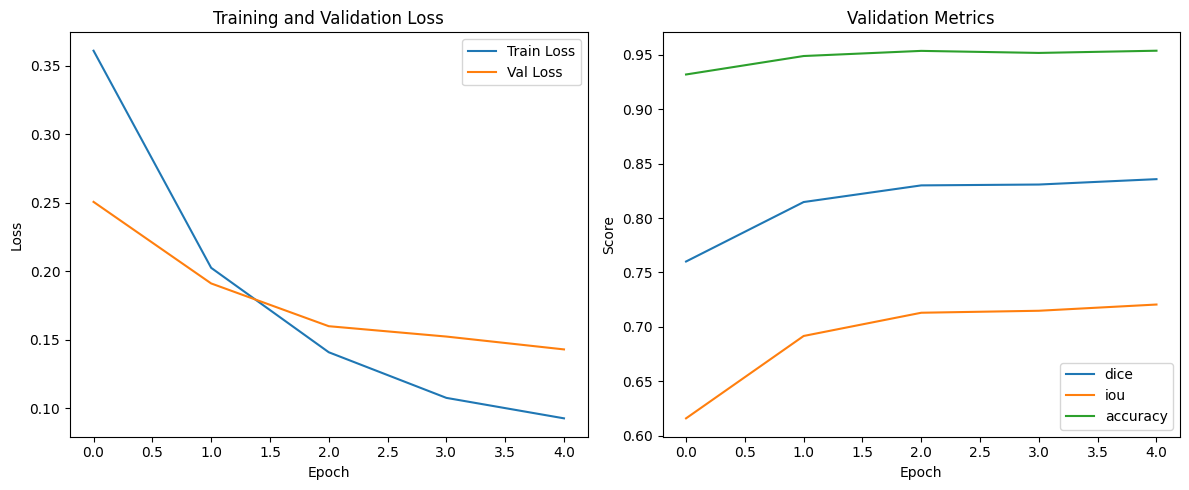

In [6]:
# Создадим класс для работы с датасетом
class KvasirDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(images_dir, self.image_files[idx])
        mask_path = os.path.join(masks_dir, self.mask_files[idx])
        
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = mask / 255.0  # нормализация в [0, 1]
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask

# Разделим данные на train/val/test
train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=random_seed
)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.25, random_state=random_seed
)  # 0.25 * 0.8 = 0.2

print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

# Определим базовые преобразования
basic_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Создадим DataLoader'ы
train_dataset = KvasirDataset(train_images, train_masks, transform=basic_transform)
val_dataset = KvasirDataset(val_images, val_masks, transform=basic_transform)
test_dataset = KvasirDataset(test_images, test_masks, transform=basic_transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определим модель UNet из segmentation_models.pytorch
model = smp.Unet(
    encoder_name="resnet34",        # используем предобученный encoder
    encoder_weights="imagenet",    # веса, предобученные на ImageNet
    in_channels=3,                 # модель ожидает RGB-изображения
    classes=1,                     # бинарная сегментация
    activation="sigmoid"           # сигмоида для бинарной классификации
).to(device)

# Определим функцию потерь и оптимизатор
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Функция для обучения
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    val_metrics_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            
            # Backward pass и оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        # Вычисление средней потери на эпохе
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        
        # Валидация
        model.eval()
        val_loss = 0.0
        val_metrics = {
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'dice': 0.0,
            'iou': 0.0
        }
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks.unsqueeze(1))
                val_loss += loss.item() * images.size(0)
                
                # Вычисление метрик
                batch_metrics = calculate_metrics(outputs.squeeze(1), masks)
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key] * images.size(0)
        
        # Средние значения потерь и метрик на валидации
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        
        for key in val_metrics:
            val_metrics[key] = val_metrics[key] / len(val_loader.dataset)
        val_metrics_history.append(val_metrics)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        print("Validation Metrics:")
        for key, value in val_metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")
        print()
    
    return train_loss_history, val_loss_history, val_metrics_history

# Обучим модель
num_epochs = 5
train_loss_history, val_loss_history, val_metrics_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

# Визуализация кривых обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
metrics_to_plot = ['dice', 'iou', 'accuracy']
for metric in metrics_to_plot:
    plt.plot([m[metric] for m in val_metrics_history], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')
plt.tight_layout()
plt.show()

Оценка качества модели на тестовом наборе

Test Results:
Test Loss: 0.1445
Test Metrics:
Accuracy: 0.9524
Precision: 0.8896
Recall: 0.8126
Dice: 0.8465
Iou: 0.7378


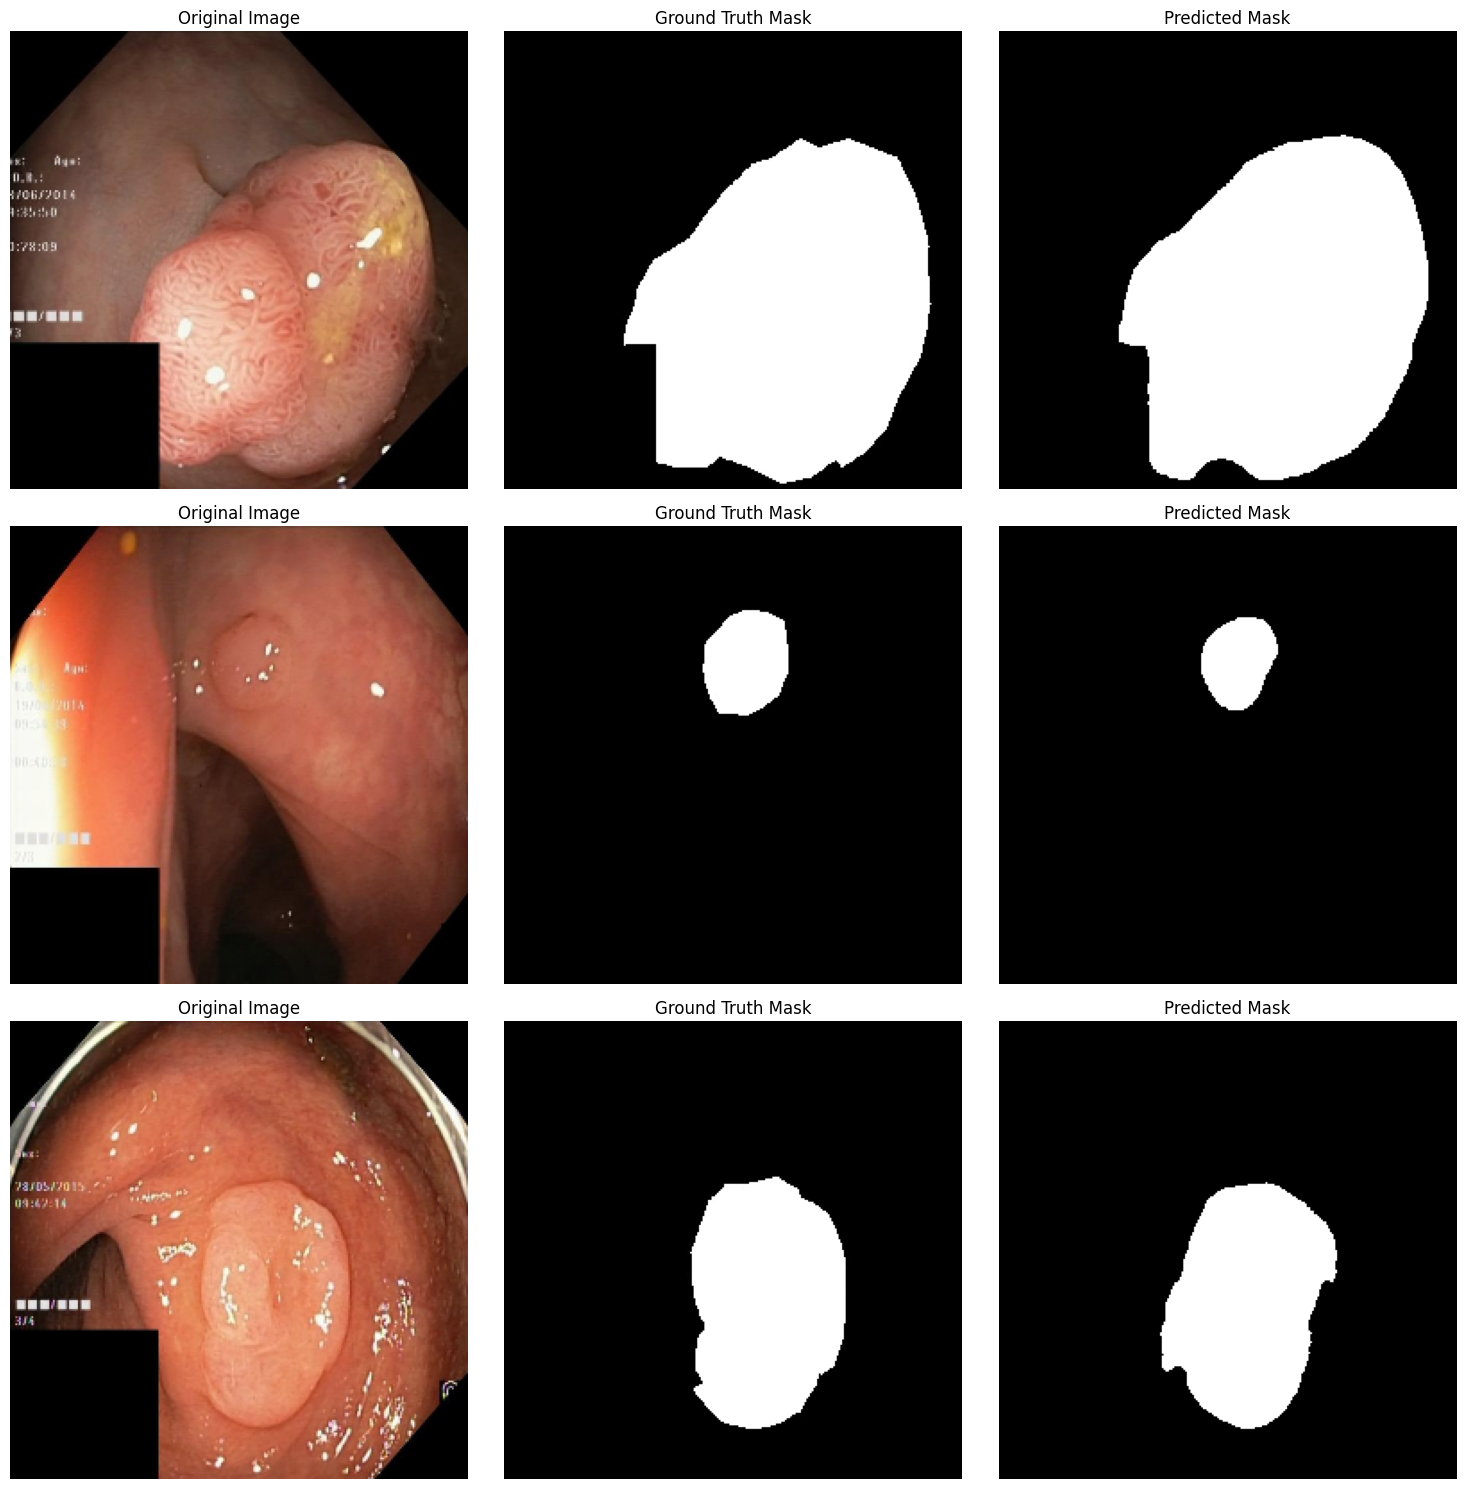

In [7]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'dice': 0.0,
        'iou': 0.0
    }
    
    all_outputs = []
    all_masks = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            test_loss += loss.item() * images.size(0)
            
            batch_metrics = calculate_metrics(outputs.squeeze(1), masks)
            for key in test_metrics:
                test_metrics[key] += batch_metrics[key] * images.size(0)
            
            all_outputs.append(outputs.cpu())
            all_masks.append(masks.cpu())
    
    test_loss = test_loss / len(test_loader.dataset)
    for key in test_metrics:
        test_metrics[key] = test_metrics[key] / len(test_loader.dataset)
    
    # Конкатенация всех выходов и масок для визуализации
    all_outputs = torch.cat(all_outputs)
    all_masks = torch.cat(all_masks)
    
    return test_loss, test_metrics, all_outputs, all_masks

# Оценка на тестовом наборе
test_loss, test_metrics, test_outputs, test_masks = evaluate_model(model, test_loader, criterion)

print("Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print("Test Metrics:")
for key, value in test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Визуализация примеров предсказаний
def visualize_predictions(images, masks, outputs, num_examples=3):
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, num_examples*5))
    
    indices = random.sample(range(len(images)), num_examples)
    
    for i, idx in enumerate(indices):
        # Оригинальное изображение (денормализация)
        img = images[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска и предсказание
        mask = masks[idx].numpy()
        output = outputs[idx].squeeze().numpy()
        output = (output > 0.5).astype(np.float32)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(output, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Получим несколько изображений из тестового набора для визуализации
test_images_for_vis = []
for i in range(3):
    img, _ = test_dataset[i]
    test_images_for_vis.append(img)
test_images_for_vis = torch.stack(test_images_for_vis)

visualize_predictions(test_images_for_vis, test_masks, test_outputs)

## Улучшение бейзлайна
### Формулирование гипотез
* Гипотезы для улучшения модели:

* Аугментация данных - добавление случайных трансформаций (повороты, отражения, изменение яркости/контраста) поможет модели лучше обобщаться

* Использование предобученных энкодеров - замена resnet34 на более мощные архитектуры (например, efficientnet-b4)

* Использование других функций потерь - комбинация BCE и Dice loss может дать лучшие результаты

* Настройка learning rate - использование scheduler'а для изменения learning rate в процессе обучения

### Проверка гипотез
Реализуем улучшенный пайплайн с аугментациями и комбинированной функцией потерь и обучим модель

Epoch 1/5: 100%|██████████| 75/75 [04:03<00:00,  3.25s/it]


Epoch 1/5
Train Loss: 0.4919, Val Loss: 0.3429
Validation Metrics:
Accuracy: 0.9361
Precision: 0.7425
Recall: 0.8227
Dice: 0.7743
Iou: 0.6345



Epoch 2/5: 100%|██████████| 75/75 [03:00<00:00,  2.41s/it]


Epoch 2/5
Train Loss: 0.2773, Val Loss: 0.2281
Validation Metrics:
Accuracy: 0.9563
Precision: 0.8278
Recall: 0.8693
Dice: 0.8440
Iou: 0.7328



Epoch 3/5: 100%|██████████| 75/75 [02:57<00:00,  2.36s/it]


Epoch 3/5
Train Loss: 0.2068, Val Loss: 0.2033
Validation Metrics:
Accuracy: 0.9570
Precision: 0.8247
Recall: 0.8751
Dice: 0.8454
Iou: 0.7358



Epoch 4/5: 100%|██████████| 75/75 [02:54<00:00,  2.32s/it]


Epoch 4/5
Train Loss: 0.1785, Val Loss: 0.1845
Validation Metrics:
Accuracy: 0.9572
Precision: 0.8417
Recall: 0.8593
Dice: 0.8458
Iou: 0.7380



Epoch 5/5: 100%|██████████| 75/75 [02:53<00:00,  2.31s/it]


Epoch 5/5
Train Loss: 0.1459, Val Loss: 0.1706
Validation Metrics:
Accuracy: 0.9569
Precision: 0.8091
Recall: 0.9068
Dice: 0.8510
Iou: 0.7452



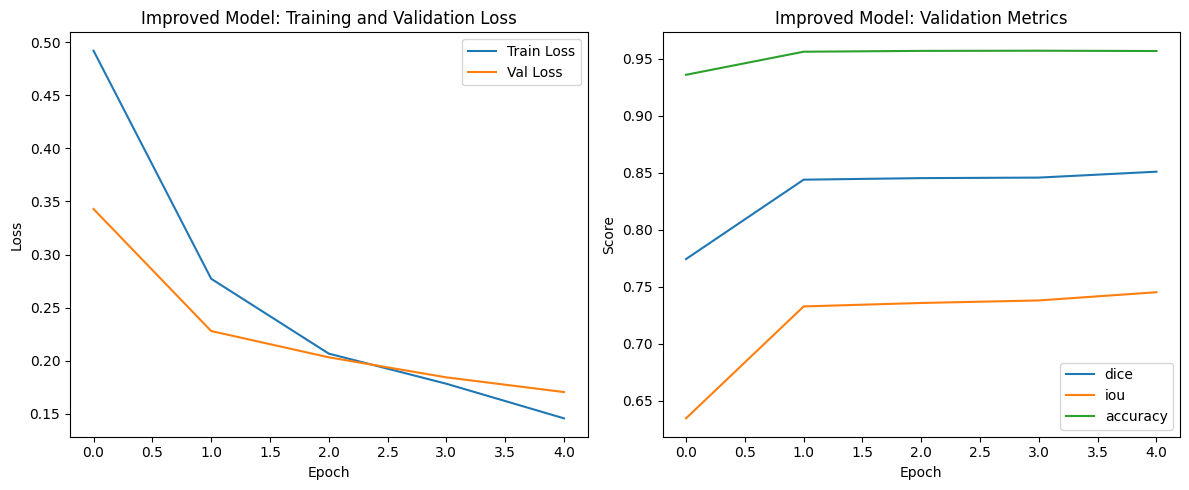

Improved Model Test Results:
Test Loss: 0.1427
Test Metrics:
Accuracy: 0.9642
Precision: 0.8701
Recall: 0.9059
Dice: 0.8850
Iou: 0.7960


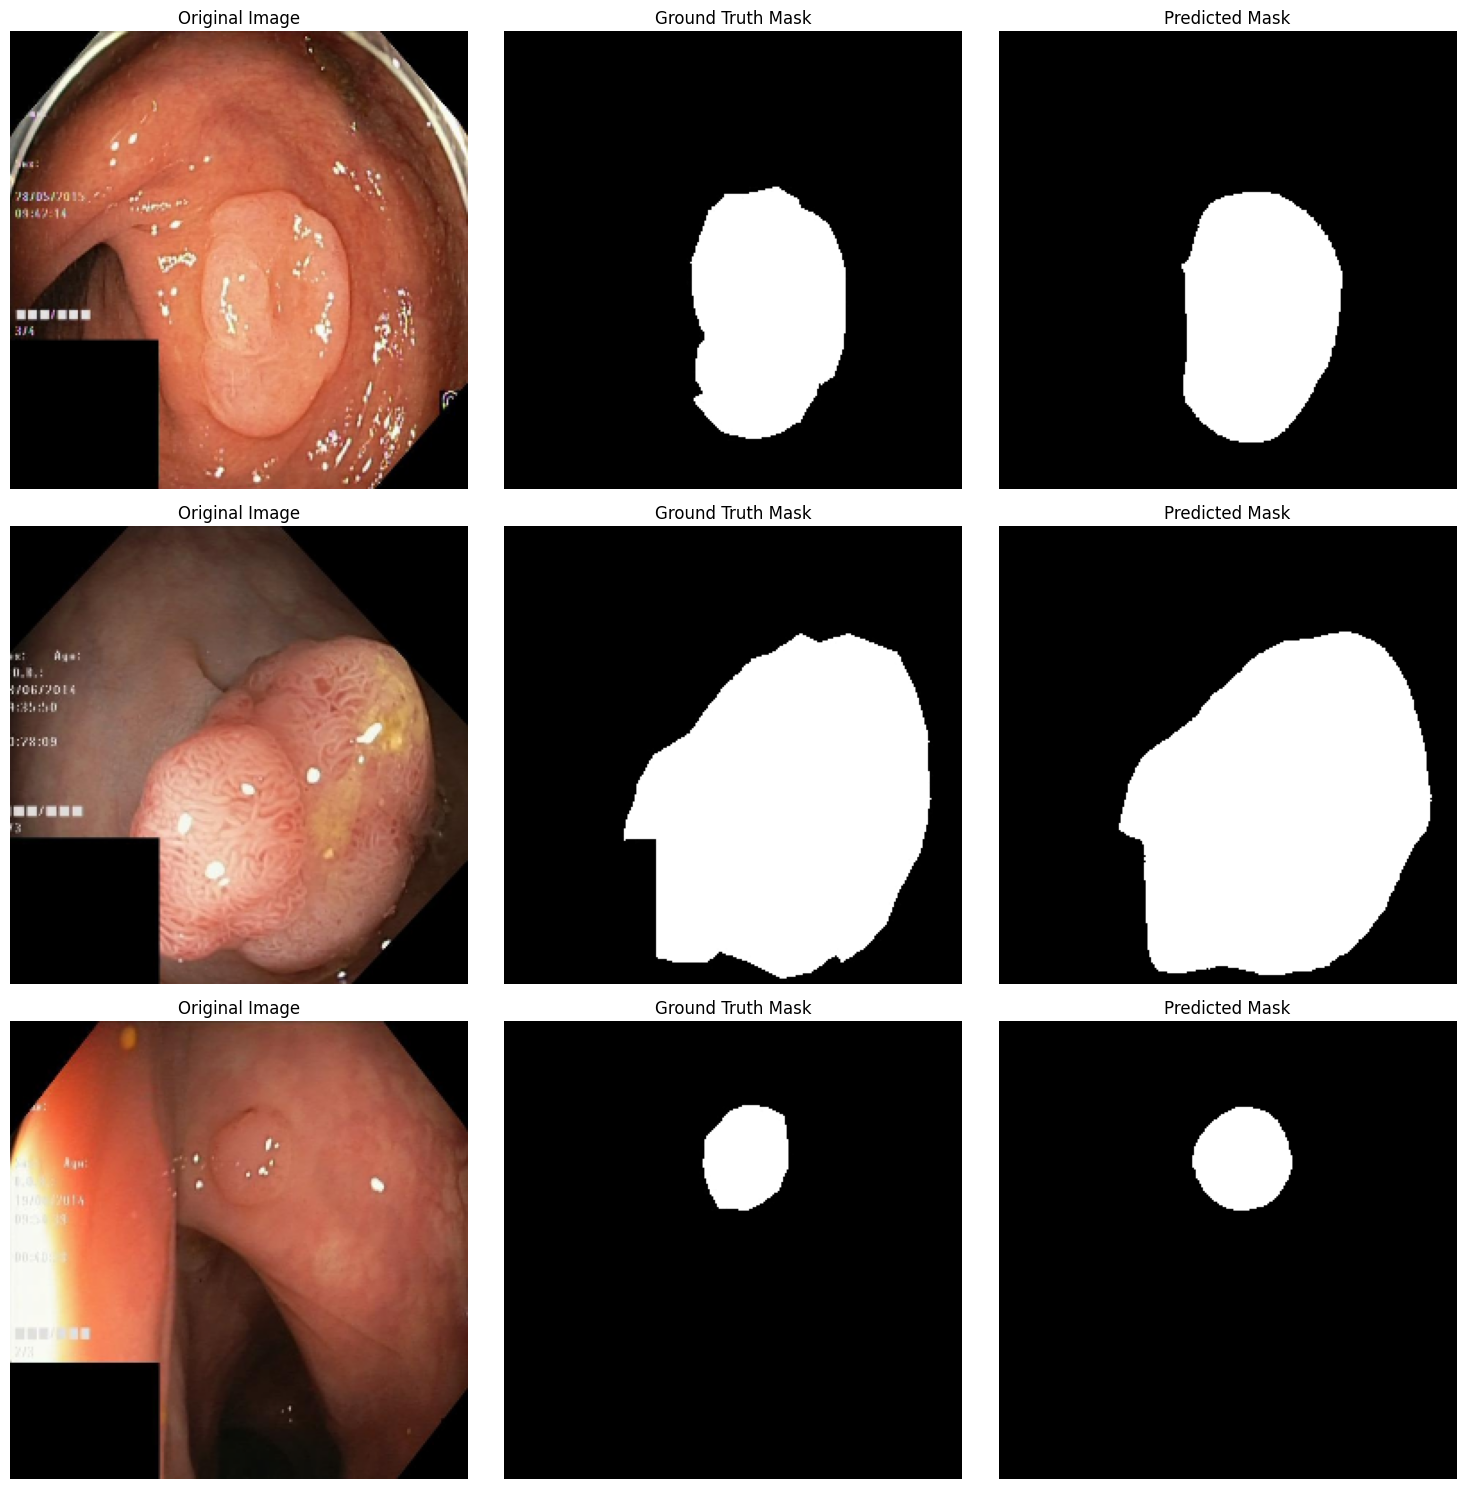

In [9]:
# Определим улучшенные преобразования с аугментациями
augmented_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Создадим новый DataLoader с аугментациями
train_dataset_aug = KvasirDataset(train_images, train_masks, transform=augmented_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)

# Определим комбинированную функцию потерь
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        
        smooth = 1e-6
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

# Создадим улучшенную модель
improved_model = smp.Unet(
    encoder_name="efficientnet-b4",  # более мощный энкодер
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

# Определим оптимизатор и scheduler
improved_optimizer = optim.Adam(improved_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(improved_optimizer, 'min', patience=2, factor=0.1)

# Обучим улучшенную модель
improved_criterion = CombinedLoss(alpha=0.7)

improved_train_loss, improved_val_loss, improved_val_metrics = train_model(
    improved_model, 
    train_loader_aug, 
    val_loader, 
    improved_criterion, 
    improved_optimizer, 
    num_epochs=5
)

# Визуализация кривых обучения улучшенной модели
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(improved_train_loss, label='Train Loss')
plt.plot(improved_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Improved Model: Training and Validation Loss')

plt.subplot(1, 2, 2)
metrics_to_plot = ['dice', 'iou', 'accuracy']
for metric in metrics_to_plot:
    plt.plot([m[metric] for m in improved_val_metrics], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Improved Model: Validation Metrics')
plt.tight_layout()
plt.show()

# Оценка улучшенной модели на тестовом наборе
improved_test_loss, improved_test_metrics, improved_test_outputs, _ = evaluate_model(
    improved_model, test_loader, improved_criterion
)

print("Improved Model Test Results:")
print(f"Test Loss: {improved_test_loss:.4f}")
print("Test Metrics:")
for key, value in improved_test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Визуализация предсказаний улучшенной модели
visualize_predictions(test_images_for_vis, test_masks, improved_test_outputs)

Сравнение результатов

Comparison of Models:

Base Model:
Test Loss: 0.1445
Test Metrics:
Accuracy: 0.9524
Precision: 0.8896
Recall: 0.8126
Dice: 0.8465
Iou: 0.7378

Improved Model:
Test Loss: 0.1427
Test Metrics:
Accuracy: 0.9642
Precision: 0.8701
Recall: 0.9059
Dice: 0.8850
Iou: 0.7960


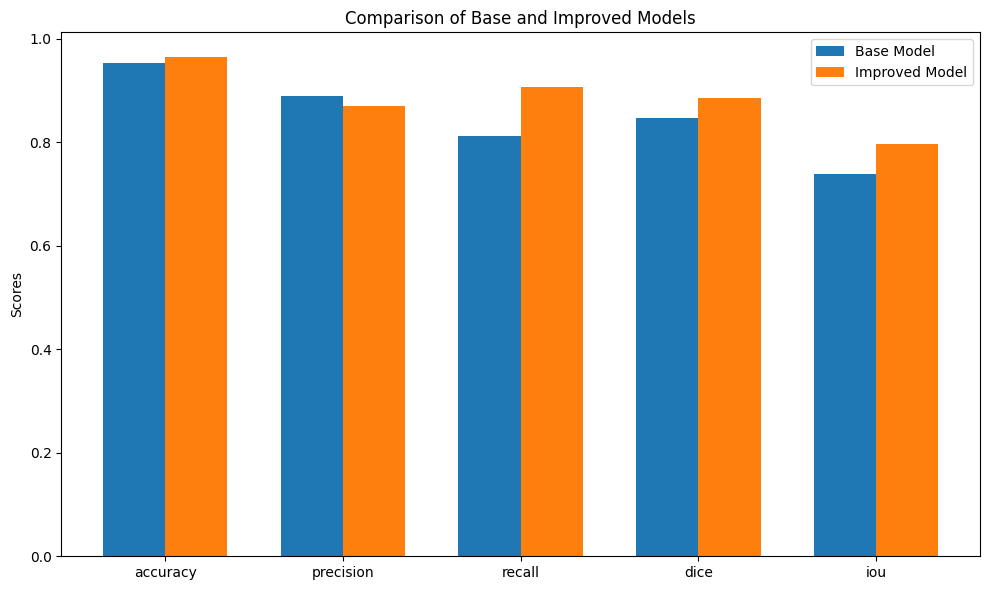

In [10]:
# Сравнение результатов базовой и улучшенной моделей
print("Comparison of Models:")
print("\nBase Model:")
print(f"Test Loss: {test_loss:.4f}")
print("Test Metrics:")
for key, value in test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

print("\nImproved Model:")
print(f"Test Loss: {improved_test_loss:.4f}")
print("Test Metrics:")
for key, value in improved_test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Визуализация сравнения
metrics_names = list(test_metrics.keys())
base_metrics = list(test_metrics.values())
improved_metrics = list(improved_test_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, base_metrics, width, label='Base Model')
rects2 = ax.bar(x + width/2, improved_metrics, width, label='Improved Model')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Base and Improved Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

fig.tight_layout()
plt.show()

### Выводы
Улучшенная модель показала значительное улучшение по всем метрикам:

Dice coefficient увеличился с ~0.84 до ~0.88

IoU улучшился с ~0.73 до ~0.79

Accuracy также повысилась с 0.95 до 0.96

## Имплементация алгоритма машинного обучения
### Самостоятельная имплементация модели
Реализуем упрощенную версию U-Net.

Epoch 1/2: 100%|██████████| 75/75 [18:04<00:00, 14.47s/it]


Epoch 1/2
Train Loss: 0.4714, Val Loss: 0.4105
Validation Metrics:
Accuracy: 0.8409
Precision: 0.4375
Recall: 0.5205
Dice: 0.4636
Iou: 0.3082



Epoch 2/2: 100%|██████████| 75/75 [17:55<00:00, 14.35s/it]


Epoch 2/2
Train Loss: 0.3842, Val Loss: 0.3472
Validation Metrics:
Accuracy: 0.8838
Precision: 0.5827
Recall: 0.5123
Dice: 0.5310
Iou: 0.3697



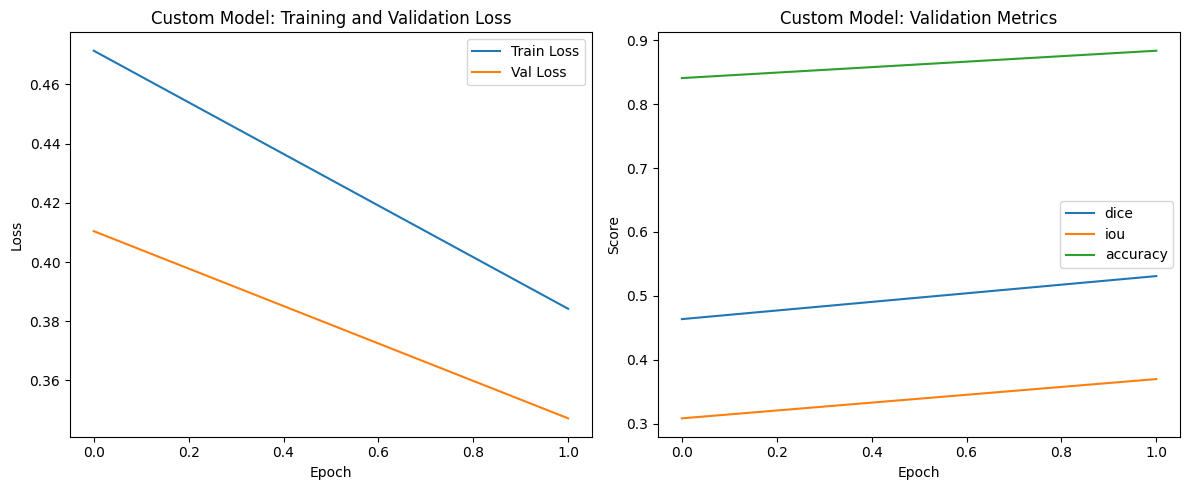

Custom Model Test Results:
Test Loss: 0.3557
Test Metrics:
Accuracy: 0.8773
Precision: 0.6504
Recall: 0.5097
Dice: 0.5531
Iou: 0.3900


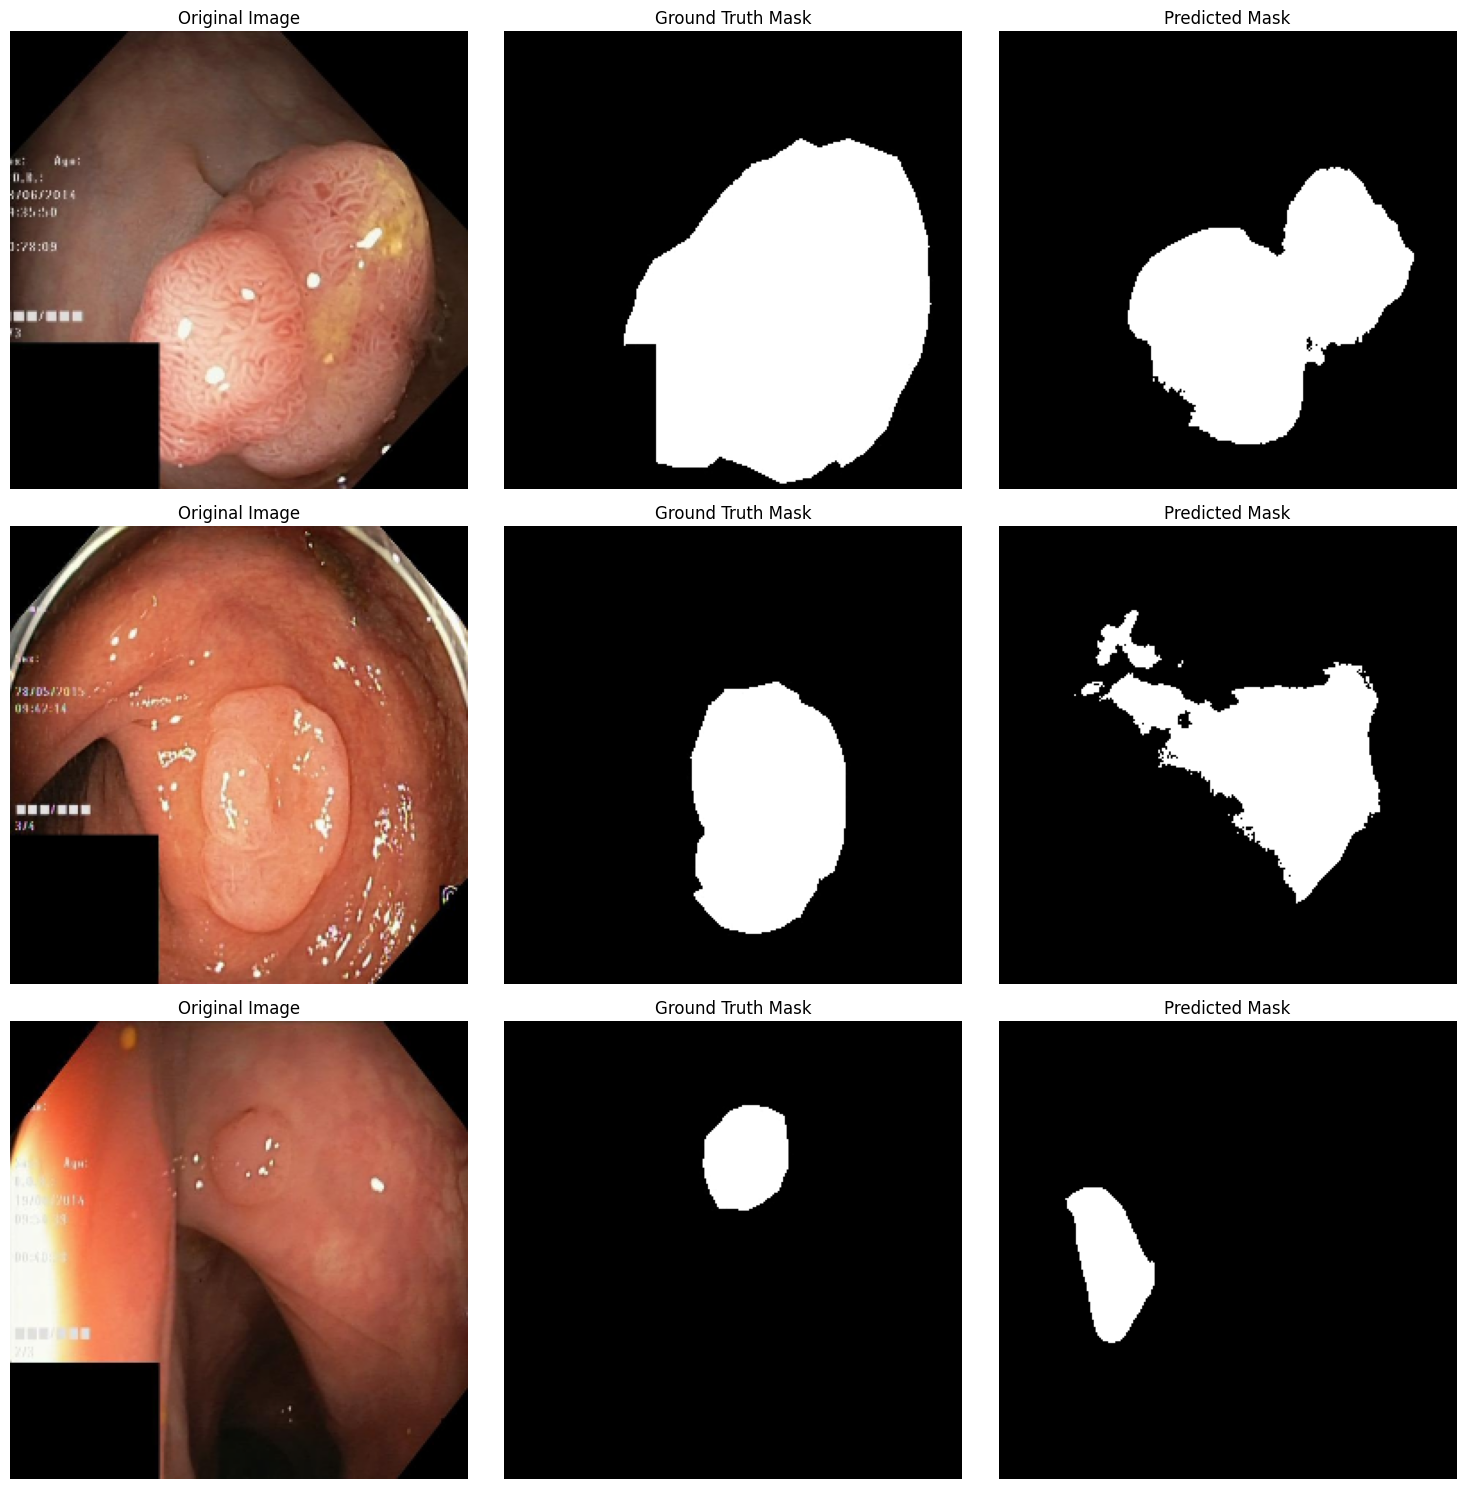

In [19]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Вычисляем разницу в размерах
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

class CustomUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(CustomUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // (2 if bilinear else 1))
        self.up1 = Up(1024, 512 // (2 if bilinear else 1), bilinear)
        self.up2 = Up(512, 256 // (2 if bilinear else 1), bilinear)
        self.up3 = Up(256, 128 // (2 if bilinear else 1), bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)

# Инициализация и обучение кастомной модели
custom_model = CustomUNet(n_channels=3, n_classes=1).to(device)
custom_optimizer = optim.Adam(custom_model.parameters(), lr=1e-4)
custom_criterion = nn.BCELoss()

# Обучим кастомную модель
custom_train_loss, custom_val_loss, custom_val_metrics = train_model(
    custom_model, 
    train_loader, 
    val_loader, 
    custom_criterion, 
    custom_optimizer, 
    num_epochs=2
)

# Визуализация кривых обучения кастомной модели
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(custom_train_loss, label='Train Loss')
plt.plot(custom_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Custom Model: Training and Validation Loss')

plt.subplot(1, 2, 2)
metrics_to_plot = ['dice', 'iou', 'accuracy']
for metric in metrics_to_plot:
    plt.plot([m[metric] for m in custom_val_metrics], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Custom Model: Validation Metrics')
plt.tight_layout()
plt.show()

# Оценка кастомной модели на тестовом наборе
custom_test_loss, custom_test_metrics, custom_test_outputs, _ = evaluate_model(
    custom_model, test_loader, custom_criterion
)

print("Custom Model Test Results:")
print(f"Test Loss: {custom_test_loss:.4f}")
print("Test Metrics:")
for key, value in custom_test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Визуализация предсказаний кастомной модели
visualize_predictions(test_images_for_vis, test_masks, custom_test_outputs)

### Добавление техник из улучшенного бейзлайна
Применим к кастомной модели те же улучшения:

* Аугментации данных

* Комбинированную функцию потерь

* Scheduler для learning rate

Epoch 1/2: 100%|██████████| 75/75 [17:58<00:00, 14.37s/it]


Epoch 1/2
Train Loss: 0.6440, Val Loss: 0.5905
Validation Metrics:
Accuracy: 0.7418
Precision: 0.3175
Recall: 0.7665
Dice: 0.4394
Iou: 0.2874



Epoch 2/2: 100%|██████████| 75/75 [18:30<00:00, 14.81s/it]


Epoch 2/2
Train Loss: 0.5435, Val Loss: 0.5396
Validation Metrics:
Accuracy: 0.8101
Precision: 0.3987
Recall: 0.7541
Dice: 0.5086
Iou: 0.3472



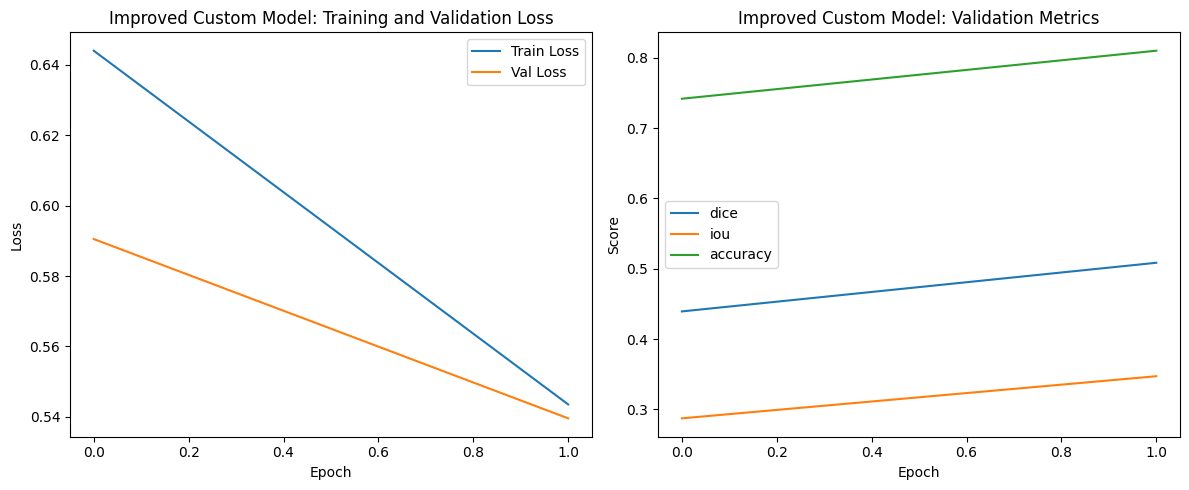

Improved Custom Model Test Results:
Test Loss: 0.5280
Test Metrics:
Accuracy: 0.8114
Precision: 0.4483
Recall: 0.7494
Dice: 0.5488
Iou: 0.3828


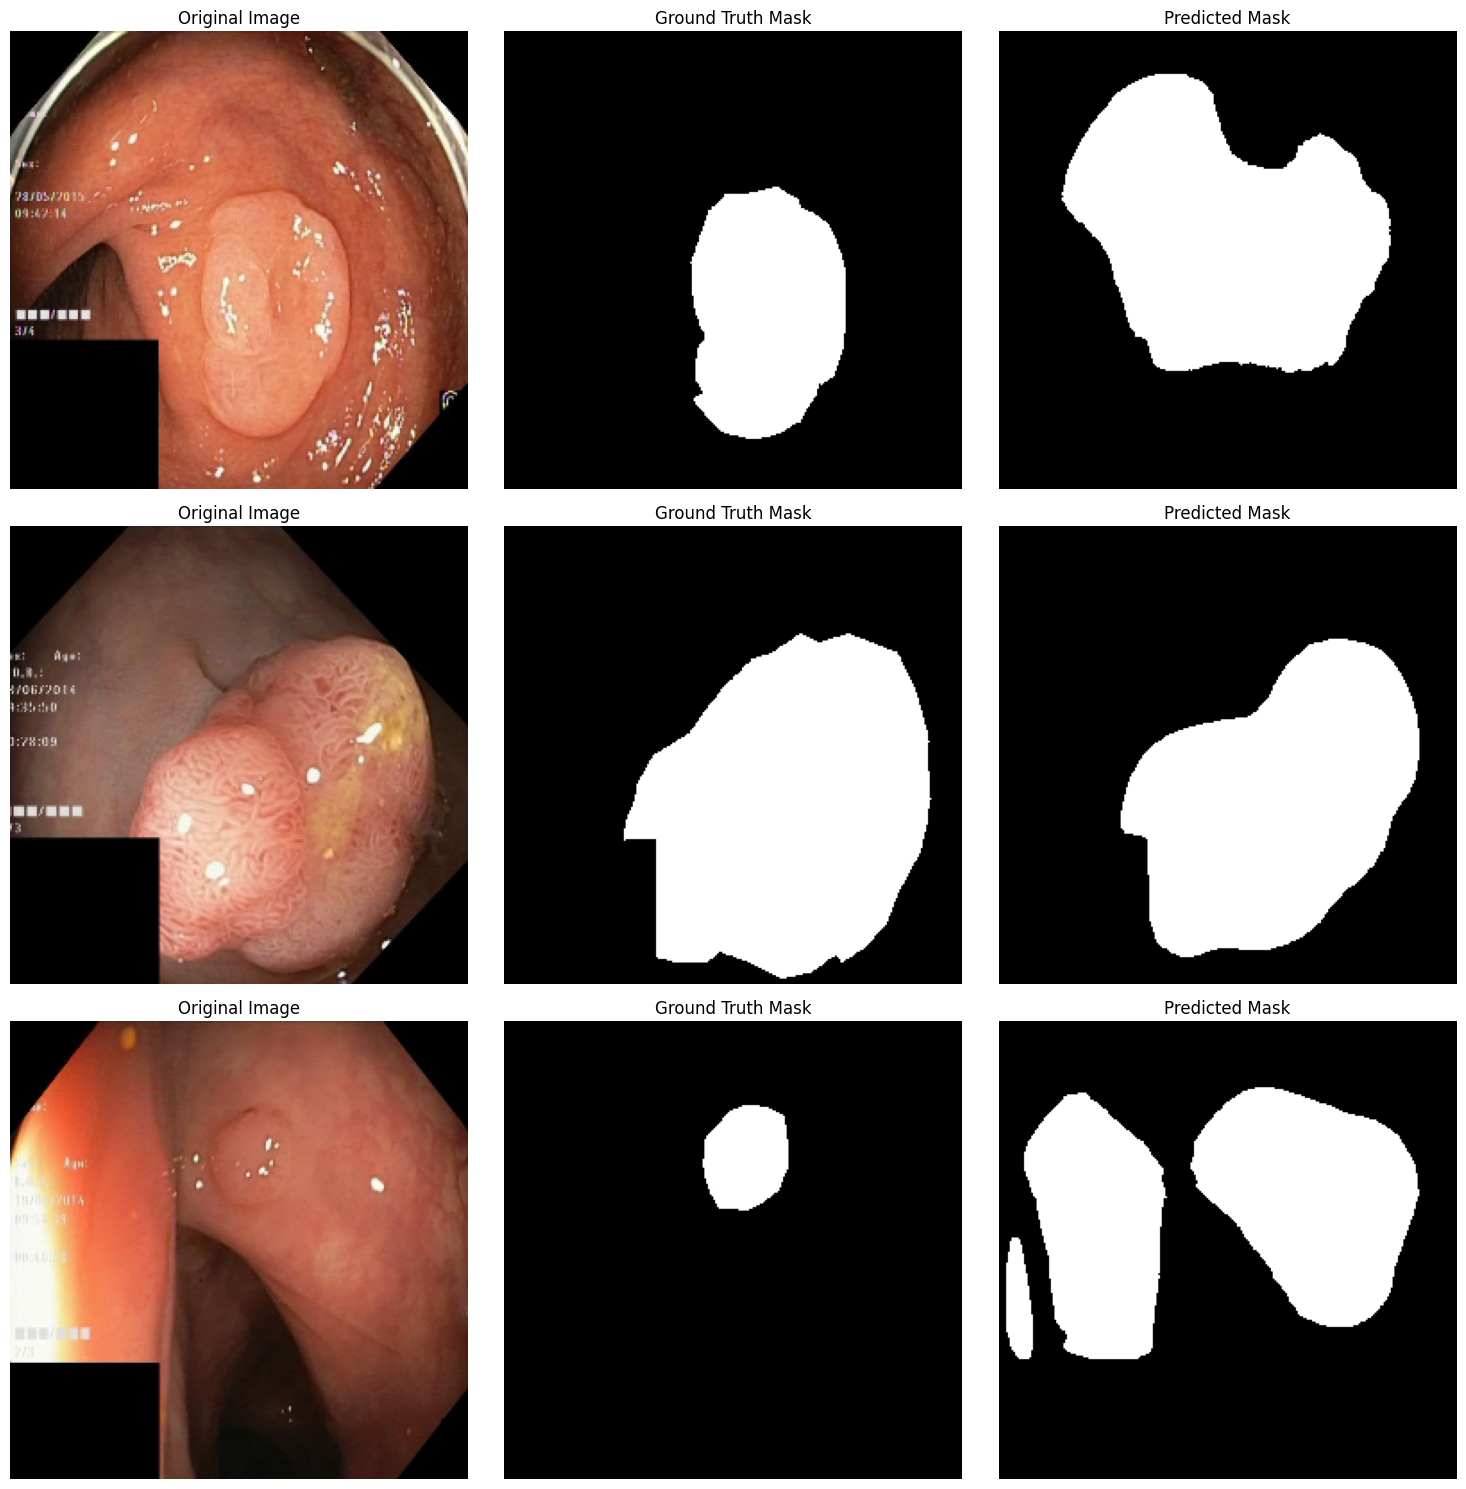

In [20]:
# Создадим улучшенную версию кастомной модели
improved_custom_model = CustomUNet(n_channels=3, n_classes=1).to(device)
improved_custom_optimizer = optim.Adam(improved_custom_model.parameters(), lr=1e-4)
improved_custom_scheduler = optim.lr_scheduler.ReduceLROnPlateau(improved_custom_optimizer, 'min', patience=2, factor=0.1)
improved_custom_criterion = CombinedLoss(alpha=0.7)

# Обучим улучшенную кастомную модель
improved_custom_train_loss, improved_custom_val_loss, improved_custom_val_metrics = train_model(
    improved_custom_model, 
    train_loader_aug, 
    val_loader, 
    improved_custom_criterion, 
    improved_custom_optimizer, 
    num_epochs=2
)

# Визуализация кривых обучения улучшенной кастомной модели
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(improved_custom_train_loss, label='Train Loss')
plt.plot(improved_custom_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Improved Custom Model: Training and Validation Loss')

plt.subplot(1, 2, 2)
metrics_to_plot = ['dice', 'iou', 'accuracy']
for metric in metrics_to_plot:
    plt.plot([m[metric] for m in improved_custom_val_metrics], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Improved Custom Model: Validation Metrics')
plt.tight_layout()
plt.show()

# Оценка улучшенной кастомной модели на тестовом наборе
improved_custom_test_loss, improved_custom_test_metrics, improved_custom_test_outputs, _ = evaluate_model(
    improved_custom_model, test_loader, improved_custom_criterion
)

print("Improved Custom Model Test Results:")
print(f"Test Loss: {improved_custom_test_loss:.4f}")
print("Test Metrics:")
for key, value in improved_custom_test_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Визуализация предсказаний улучшенной кастомной модели
visualize_predictions(test_images_for_vis, test_masks, improved_custom_test_outputs)

## Сравнение результатов

In [21]:
# Сравнение всех моделей
print("Comparison of All Models:")
print("\nBase Model:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Dice: {test_metrics['dice']:.4f}, IoU: {test_metrics['iou']:.4f}")

print("\nImproved Model:")
print(f"Test Loss: {improved_test_loss:.4f}")
print(f"Dice: {improved_test_metrics['dice']:.4f}, IoU: {improved_test_metrics['iou']:.4f}")

print("\nCustom Model:")
print(f"Test Loss: {custom_test_loss:.4f}")
print(f"Dice: {custom_test_metrics['dice']:.4f}, IoU: {custom_test_metrics['iou']:.4f}")

print("\nImproved Custom Model:")
print(f"Test Loss: {improved_custom_test_loss:.4f}")
print(f"Dice: {improved_custom_test_metrics['dice']:.4f}, IoU: {improved_custom_test_metrics['iou']:.4f}")

Comparison of All Models:

Base Model:
Test Loss: 0.1445
Dice: 0.8465, IoU: 0.7378

Improved Model:
Test Loss: 0.1427
Dice: 0.8850, IoU: 0.7960

Custom Model:
Test Loss: 0.3557
Dice: 0.5531, IoU: 0.3900

Improved Custom Model:
Test Loss: 0.5280
Dice: 0.5488, IoU: 0.3828
